# ERBB Signaling Network Analysis

This notebook serves as the main analysis tool for the ERBB signaling network. It integrates various analyses, including stable state identification, drug target prediction, and biomarker analysis. The goal is to understand the dynamics of the ERBB signaling pathway and its implications in breast cancer.

Model saved to ../data/models/ERBB_model.boon
Analyzing stable states...
Found 3 stable states


,0,1,2
0,True,False,True
1,False,False,True
2,True,False,True
3,True,False,True
4,False,False,False



Identifying potential drug targets...
Top 5 drug targets:
- AKT1: Score = 14
- ER_alpha: Score = 12
- ERBB2: Score = 10
- c_MYC: Score = 10
- ERBB1: Score = 8

Analyzing biomarkers...
Top 5 biomarkers:
- p27: Score = 60.80
- p21: Score = 60.80
- AKT1: Score = 42.80
- ER_alpha: Score = 42.40
- ERBB2: Score = 42.00
Figure saved to ../results/figures/stable_states_activity.png


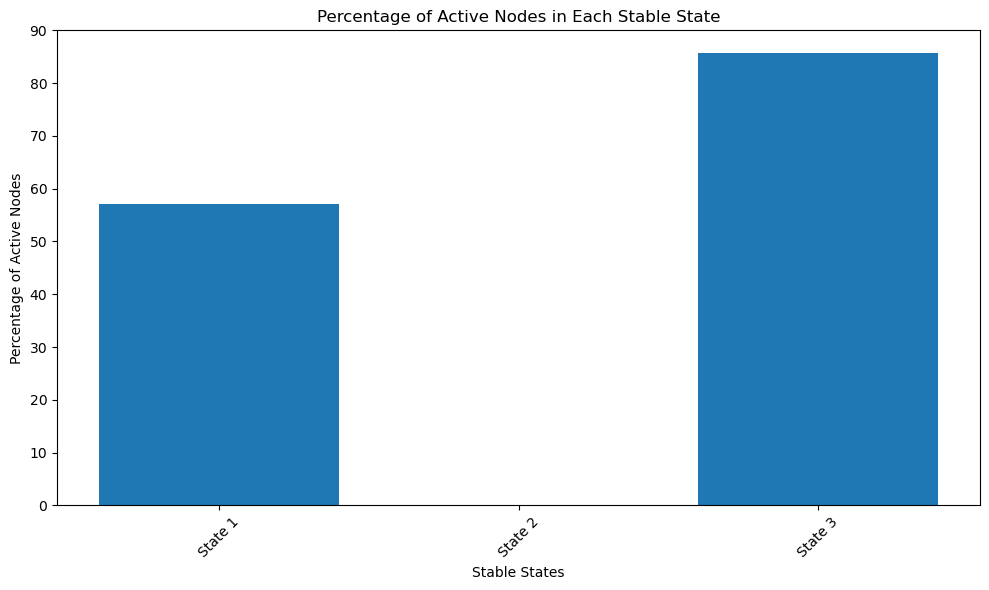

Figure saved to ../results/figures/drug_targets.png


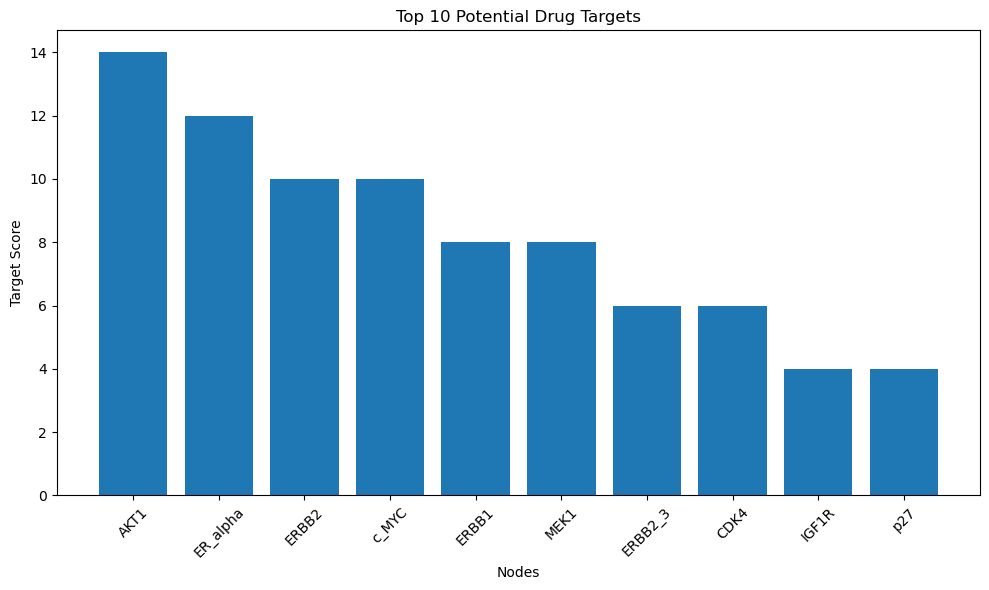

Figure saved to ../results/figures/biomarkers.png


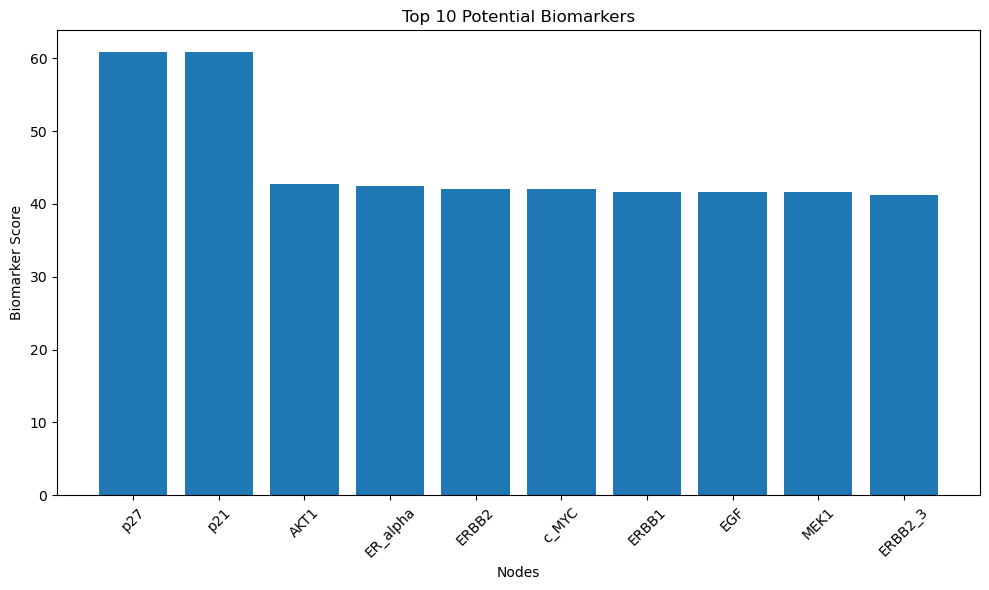

Results saved to ../results/stable_states.csv
Results saved to ../results/drug_targets.csv
Results saved to ../results/biomarkers.csv

Analysis complete! All results and visualizations have been saved.


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import importlib

if 'src.utils.io_utils' in sys.modules:
    del sys.modules['src.utils.io_utils']
    
# Add the parent directory to sys.path to allow importing from src
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import our modules
from src.models.ERBB_Boolean import model
from src.analysis.stable_states import analyze_stable_states
from src.analysis.drug_targets import identify_drug_targets
from src.analysis.biomarker_analysis import analyze_biomarkers
from src.utils.io_utils import *
import pandas as pd
import src.utils.io_utils
importlib.reload(src.utils.io_utils)
from src.utils.io_utils import save_model, load_model, save_results, save_visualization

# Save the ERBB model first
save_model(model, '../data/models/ERBB_model.boon')

# Load the ERBB model (demonstration of loading)
model = load_model('../data/models/ERBB_model.boon')

# Rest of your code remains the same...

# Load the ERBB model (demonstration of loading)
model = load_model('../data/models/ERBB_model.boon')

# 1. Analyze stable states
print("Analyzing stable states...")
stable_states_results = analyze_stable_states(model)
print(f"Found {stable_states_results['count']} stable states")

# Display first 5 rows of the stable states dataframe
display(stable_states_results['dataframe'].head())

# 2. Identify potential drug targets
print("\nIdentifying potential drug targets...")
drug_targets = identify_drug_targets(model)
print("Top 5 drug targets:")
for target in drug_targets[:5]:
    print(f"- {target['node']}: Score = {target['target_score']}")

# 3. Analyze biomarkers
print("\nAnalyzing biomarkers...")
biomarker_results = analyze_biomarkers(model)
print("Top 5 biomarkers:")
for marker in biomarker_results['all_biomarkers'][:5]:
    print(f"- {marker['node']}: Score = {marker['biomarker_score']:.2f}")

# 4. Visualize results
# 4.1 Visualize stable states activity
plt.figure(figsize=(10, 6))
active_percentages = [state['active_percentage'] for state in stable_states_results['states']]
state_names = [f"State {i+1}" for i in range(len(active_percentages))]
plt.bar(state_names, active_percentages)
plt.title('Percentage of Active Nodes in Each Stable State')
plt.xlabel('Stable States')
plt.ylabel('Percentage of Active Nodes')
plt.xticks(rotation=45)
plt.tight_layout()
save_visualization(plt.gcf(), '../results/figures/stable_states_activity.png')
plt.show()

# 4.2 Visualize drug target scores
plt.figure(figsize=(10, 6))
top_targets = drug_targets[:10]
target_names = [target['node'] for target in top_targets]
target_scores = [target['target_score'] for target in top_targets]
plt.bar(target_names, target_scores)
plt.title('Top 10 Potential Drug Targets')
plt.xlabel('Nodes')
plt.ylabel('Target Score')
plt.xticks(rotation=45)
plt.tight_layout()
save_visualization(plt.gcf(), '../results/figures/drug_targets.png')
plt.show()

# 4.3 Visualize biomarker scores
plt.figure(figsize=(10, 6))
top_biomarkers = biomarker_results['all_biomarkers'][:10]
biomarker_names = [marker['node'] for marker in top_biomarkers]
biomarker_scores = [marker['biomarker_score'] for marker in top_biomarkers]
plt.bar(biomarker_names, biomarker_scores)
plt.title('Top 10 Potential Biomarkers')
plt.xlabel('Nodes')
plt.ylabel('Biomarker Score')
plt.xticks(rotation=45)
plt.tight_layout()
save_visualization(plt.gcf(), '../results/figures/biomarkers.png')
plt.show()

# Save all results
save_results(pd.DataFrame(stable_states_results['states']), '../results/stable_states.csv')
save_results(pd.DataFrame(drug_targets), '../results/drug_targets.csv')
save_results(pd.DataFrame(biomarker_results['all_biomarkers']), '../results/biomarkers.csv')

print("\nAnalysis complete! All results and visualizations have been saved.")